In [1]:
# This is needed so that python finds the utils
import sys
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

$$
\newcommand{\N}{\mathbb{N}}
\newcommand{\X}{\mathcal{X}}
$$
The algorithm is as follows [1]:

**Rej-Sampler**$(P, Q)$
Random Input: $\langle x_i \mid i \in \N \rangle$ a sequence of i.i.d. samples from $Q$.

 1. Initialisation 
 
    1. For each $x \in \X$, set $p_0(x) \leftarrow 0$.
    2. Set $p^*_0 \leftarrow 0$.
    
 2. **For** $i \leftarrow 1$ to $\infty$ **do**
 
    1. Set $\alpha_i(x) \leftarrow \min\{P(x) - p_{i-1}(x), (1 - p^*_{i-1})Q(x) \} \quad \forall x \in \X$.
    2. Set $p_i(x) \leftarrow p_{i - 1}(x) + \alpha_i(x) \quad \forall x \in \X$.
    3. Set $p_i^* \leftarrow \sum_{x \in \X} p_i(x)$
    4. Set $\beta_i(x_i) \leftarrow \frac{\alpha_i(x)}{(1 - p^*_{i-1})Q(x)}$
    5. Sample $u \leftarrow \mathrm{Uniform}(0, 1)$
    6. **If** $u < \beta_i(x_i)$ **then**
    
        **return** $i, x_i$

In [2]:
def rejection_sampler(P, Q, seed, failure_threshold=1000):
    """
    P, Q - lists of positive reals that sum to one
    """
    
    np.random.seed(seed)
    
    n = len(P)
    
    # Initialisation
    alpha = [0] * n
    p = [0] * n
    p_star = 0
    
    # Rejection sampling loop
    for i in range(failure_threshold):
        
        p_star_ = 0
        
        # Step 2.A and 2.B
        for x in range(n):
            alpha[x] = np.minimum(P[x] - p[x], (1 - p_star) * Q[x])
            p[x] = p[x] + alpha[x]
            p_star_ += p[x]
            
        
        # Step 2.D and Step 2.C - we exchange these so that we don't need to keep
        # both p_star_i and p_star_{i - 1} around
        x_i = np.random.choice(n, None, p=Q)
        beta_i = alpha[x_i] / ((1 - p_star) * Q[x_i])
        
        p_star = p_star_
        
        # Step 2.E
        u = np.random.uniform()
        
        # Step 2.F
        if u < beta_i:
            return i, x_i
        
    return None

def kl_divergence(P, Q):
    return np.sum(P * (np.log(P) - np.log(Q)))
        

In [3]:
np.random.seed(42)

P = np.random.uniform(size=20)
P = P / np.sum(P)

Q = np.ones(len(P)) / len(P)

samples = []
mass = np.zeros(len(P))

for j in tqdm(range(50, 1050)):
    sample = rejection_sampler(P=P, Q=Q, seed=j, failure_threshold=1000)
    samples.append(sample)
    
    i, x_i = sample
    
    mass[x_i] += 1
    
mass = mass / np.sum(mass)

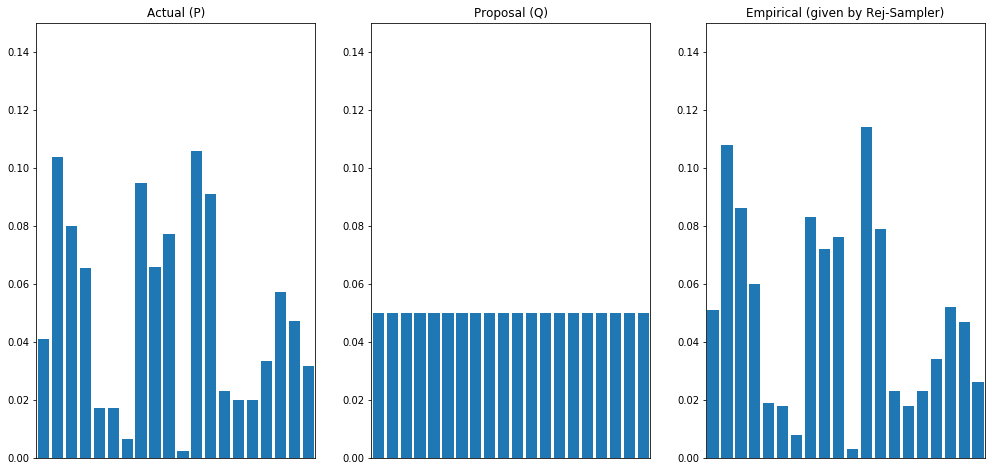

KL divergence between P and Q: 0.235


In [4]:
plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.bar(np.arange(len(P)), P)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Actual (P)")

plt.subplot(132)
plt.bar(np.arange(len(P)), Q)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Proposal (Q)")

plt.subplot(133)
plt.bar(np.arange(len(P)), mass)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Empirical (given by Rej-Sampler)")

plt.show()

print("KL divergence between P and Q: {:.3f}".format(kl_divergence(P, Q)))

1.0


1.2201752366211964

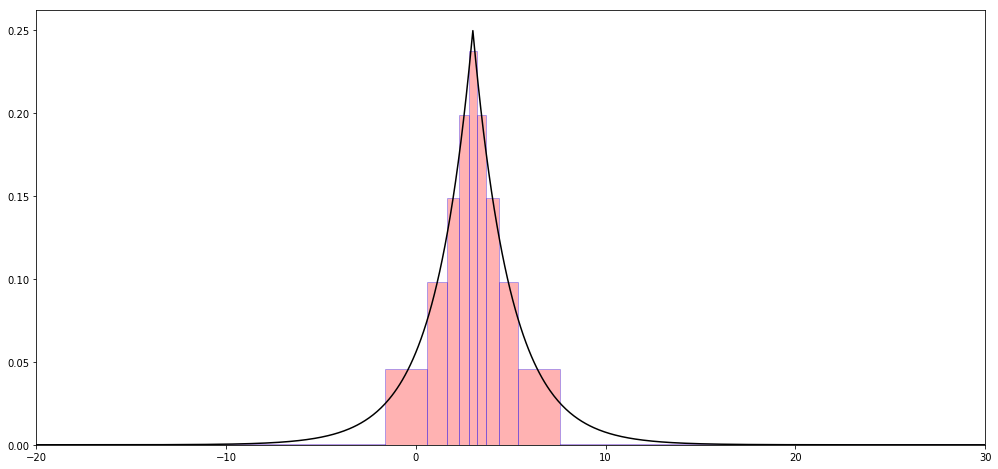

In [16]:
delta = 10e-2
b = 2
mu = 3

def laplace_pdf(x, mu, b): 
    return 1. / (2 * b) * np.exp(-np.abs(x - mu) / b)

def laplace_cdf(x, mu, b):
    ind = (x > mu).astype(np.float32)
    
    return (1 - ind) * (0.5 * np.exp(-(mu - x) / b)) + ind * (1 - 0.5 * np.exp(-(x - mu) / b))

def laplace_quantile(p, loc, scale):
    
    return loc - scale * np.sign(p - 0.5) * np.log(1 - 2 * np.abs(p - 0.5))
    
def pos_bin_edge(a, delta, mu, b):    
    return mu - b * np.log(1 - 2 * a * delta)

def neg_bin_edge(a, delta, mu, b):    
    return mu + b * np.log(1 - 2 * a * delta)
    
num_bins = (np.floor(1 / delta) + 1) // 2

pos_bin_edges = pos_bin_edge(np.arange(num_bins) + 0.5, delta, mu, b)
neg_bin_edges = neg_bin_edge(np.arange(num_bins) + 0.5, delta, mu, b)

bin_edges = np.concatenate((neg_bin_edges[::-1], pos_bin_edges))

widths = bin_edges[1:] - bin_edges[:-1]
widths = np.concatenate((100 * np.ones((1,)), widths, 100 * np.ones((1,))))

bin_edges = np.concatenate((bin_edges[:1] - 100, bin_edges))

heights = delta / widths

heights[0] /= 2
heights[-1] /= 2

xs = np.linspace(-30, 40, 1000)

plt.figure(figsize=(17,8))
plt.plot(xs,
         laplace_pdf(xs, mu, b),
         color='k')

plt.bar(x=bin_edges, 
        height=heights,
        width=widths,
        align="edge",
        alpha=0.3,
        color='r',
        edgecolor='b')

plt.xlim([-20, 30])

print(np.sum(widths*heights))

np.sum(heights)

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



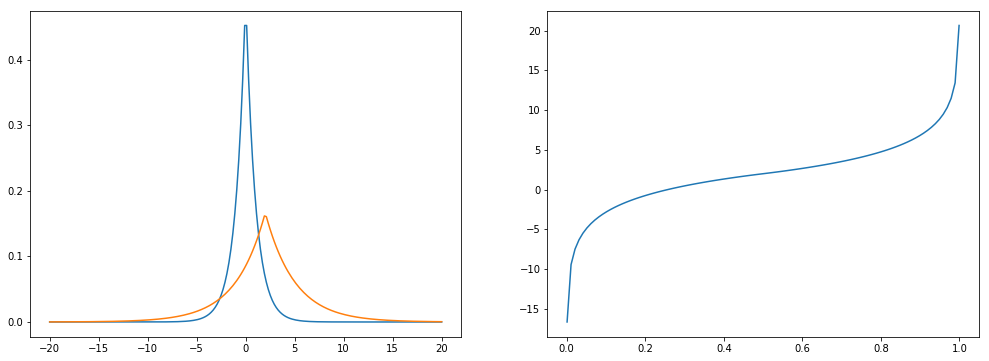

In [7]:
prior = tfd.Laplace(loc=0., scale=1.)
posterior = tfd.Laplace(loc=2., scale=3.)

tf.random.set_random_seed(42)

xs = np.linspace(-20, 20, 200)
ys = np.linspace(0.001, 0.999, 100)

plt.figure(figsize=(17, 6))

plt.subplot(121)
plt.plot(xs, prior.prob(xs))
plt.plot(xs, posterior.prob(xs))

plt.subplot(122)
plt.plot(ys, laplace_quantile(ys, 2., 3.))

plt.show()

In [8]:
def create_bins_and_masses(dist, quantile_fn, delta, tail_length=100.):
    num_edges = int(np.floor(1. / delta) + 1)

    percentages = np.arange(0., 1., delta) + delta / 2
    
    edges = quantile_fn(percentages, loc=dist.loc, scale=dist.scale)
    
    widths = tail_length * np.ones((num_edges,))
    widths[1:-1] = edges[1:] - edges[:-1]
    
    mass = delta / widths
    
    mass /= np.sum(mass)
    
    return edges, mass

def get_prior_mass_correspondance(posterior_bins, prior):
    
    prior_mass = np.zeros((len(posterior_bins) + 1,))
    
    prior_mass[0] = prior.cdf(posterior_bins[0])
    prior_mass[1:-1] = prior.cdf(posterior_bins[1:]) - prior.cdf(posterior_bins[:-1])
    prior_mass[-1] = 1 - np.sum(prior_mass)
    
    return prior_mass
    
def get_bin(x, bins):
    
    for idx, b in enumerate(bins):
        if x < b: return idx
    else:
        idx = len(bins)
        
    return idx

In [9]:
def rejection_sampler_cts(P, P_bins, Q, Q_dist, seed, failure_threshold=1000):
    """
    """
    
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
    
    n = len(P)
    
    # Initialisation
    alpha = [0] * n
    p = [0] * n
    p_star = 0
    
    # Rejection sampling loop
    for i in range(failure_threshold):
        
        p_star_ = 0
        
        # Step 2.A and 2.B
        for x in range(n):
            alpha[x] = np.minimum(P[x] - p[x], (1 - p_star) * Q[x])
            p[x] = p[x] + alpha[x]
            p_star_ += p[x]
        
        # Step 2.D and Step 2.C - we exchange these so that we don't need to keep
        # both p_star_i and p_star_{i - 1} around
        # Note: the differences compared to the finite case is that
        # we use Q's custom sampler and we get the corresponding bin of the sample
        # in the quantized distribution
        x_i = Q_dist.sample()
        x_i_P_bin = get_bin(x_i, P_bins)
        
        beta_i = alpha[x_i_P_bin] / ((1 - p_star) * Q[x_i_P_bin])
        
        p_star = p_star_
        
        # Step 2.E
        u = np.random.uniform()
        
        # Step 2.F
        if u < beta_i:
            return i, x_i, x_i_P_bin
        
    return None


Min: 0 
First Quartile: 0.0
Median: 1.0
Third Quartile: 7.0
Max:199
Outliers below first quartile: 0
Outliers above third quartile: 1229


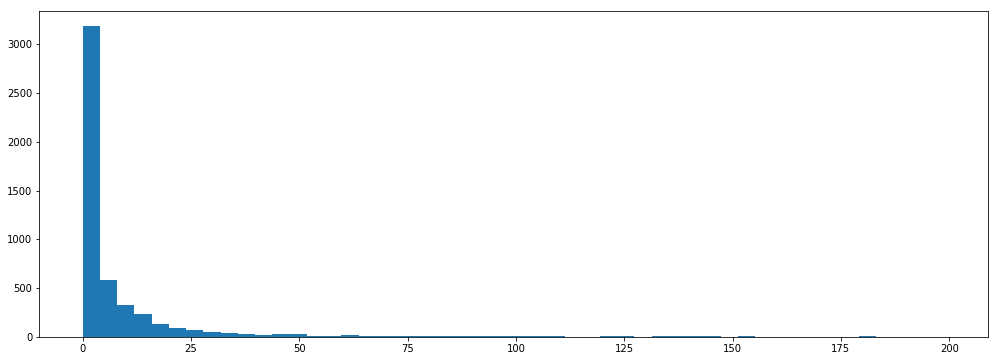

In [10]:
prior = tfd.Laplace(loc=0., scale=1.)
posterior = tfd.Laplace(loc=2., scale=3.)

P_bin, P = create_bins_and_masses(posterior, laplace_quantile, 1e-2)
Q = get_prior_mass_correspondance(P_bin, prior)

samples = []
mass = np.zeros(len(P))

num_samples = 5000

seed = 50
for j in tqdm(range(num_samples)):
    
    sample = None
    
    while sample is None:
        sample = rejection_sampler_cts(P, P_bin, Q, prior, seed=seed, failure_threshold=200)
        seed += 1
        
    samples.append(sample)
    
    i, x_i, bin_idx = sample
    
    mass[bin_idx] += 1
    
mass = mass / np.sum(mass)

indices, samps, bin_indices = zip(*samples)
indices = np.array(indices)

quarters = np.percentile(indices, [25, 50, 75])
min_idx, max_idx = np.min(indices), np.max(indices)

print("Min: {} \nFirst Quartile: {}\nMedian: {}\nThird Quartile: {}\nMax:{}".format(min_idx, 
                                                                                    quarters[0], 
                                                                                    quarters[1], 
                                                                                    quarters[2], 
                                                                                    max_idx))

print("Outliers below first quartile: {}\nOutliers above third quartile: {}".format(np.sum(indices < quarters[0]),
                                                                                    np.sum(indices > quarters[2])))
plt.figure(figsize=(17, 6))
plt.hist(indices, bins=50)
plt.show()

1.0


5000 of 5000 samples accepted
Min: 0 
First Quartile: 0.0
Median: 0.0
Third Quartile: 4.0
Max:199
Outliers below first quartile: 0
Outliers above third quartile: 1214


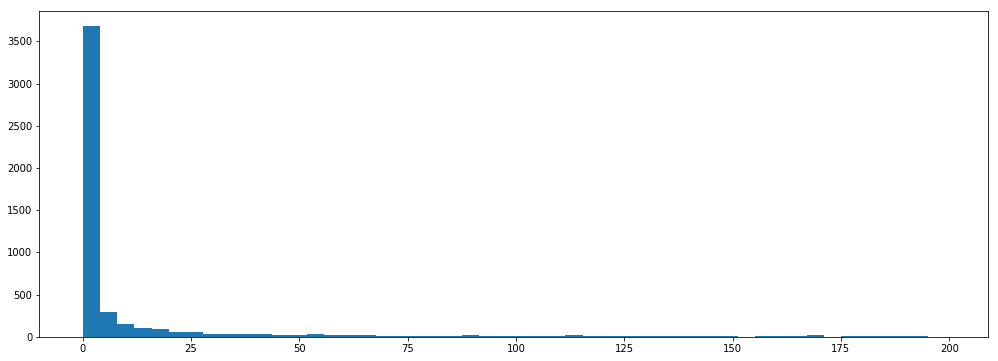

In [11]:
prior = tfd.Normal(loc=0., scale=1.)
posterior = tfd.Normal(loc=2., scale=3.)

P_bin, P = create_bins_and_masses(posterior, norm.ppf, 1e-2)
Q = get_prior_mass_correspondance(P_bin, prior)

samples_ = []
mass = np.zeros(len(P))

num_samples = 5000

seed = 50
for j in tqdm(range(num_samples)):
    
    sample = None
    
    while sample is None:
        sample = rejection_sampler_cts(P, P_bin, Q, prior, seed=seed, failure_threshold=200)
        seed += 1
        
    samples_.append(sample)
    
    i, x_i, bin_idx = sample
    
    mass[bin_idx] += 1
    
mass = mass / np.sum(mass)

print("{} of {} samples accepted".format(len(samples_), num_samples))

indices, samps_, bin_indices = zip(*samples_)
indices = np.array(indices)

quarters = np.percentile(indices, [25, 50, 75])
min_idx, max_idx = np.min(indices), np.max(indices)

print("Min: {} \nFirst Quartile: {}\nMedian: {}\nThird Quartile: {}\nMax:{}".format(min_idx, 
                                                                                    quarters[0], 
                                                                                    quarters[1], 
                                                                                    quarters[2], 
                                                                                    max_idx))

print("Outliers below first quartile: {}\nOutliers above third quartile: {}".format(np.sum(indices < quarters[0]),
                                                                                    np.sum(indices > quarters[2])))
plt.figure(figsize=(17, 6))
plt.hist(indices, bins=50)
plt.show()

(-20, 30)

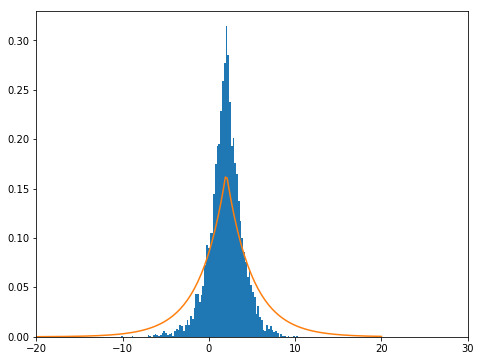

In [11]:
posterior1 = tfd.Laplace(loc=2., scale=3.)
posterior2 = tfd.Normal(loc=2., scale=3.)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(samps, bins=100, density=True)
plt.plot(xs, posterior1.prob(xs))
plt.xlim([-20, 30])

# plt.subplot(122)
# plt.hist(samps_, bins=100, density=True)
# plt.plot(xs, posterior2.prob(xs))
# plt.xlim([-20, 30])
# plt.show()

References:

[1] Communication Cost of Correlation